In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('..')
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
from joblib import delayed, Parallel, parallel_backend
import time
from operator import itemgetter
ig0 = itemgetter(0)
ig1 = itemgetter(1)
ig2 = itemgetter(2)

In [3]:
#Import python packages
from geomle import DataGenerator, geomle, mle

#Import R packages
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.numpy2ri import ri2py, py2ri
from rpy2.robjects.packages import importr
intdimr = importr('intrinsicDimension')
r_base = importr('base')

#Import C++ packages
import hein

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def calculate_time(func): 
    def inner_func(*args, **kwargs): 
        begin = time.time() 
        res = func(*args, **kwargs) 
        end = time.time()
        return res, end - begin
    return inner_func

In [116]:
# k1_sigmoid = lambda x: int(round(20 / (1 + np.exp( -0.05 * x))))
# k2_sigmoid = lambda x: int(round(60 / (1 + np.exp( -0.03 * (x + 5)))))

CPU_COUNT = os.cpu_count()
k1_log = lambda x: int(np.round(3 * np.log(1/3 * x) + 10))
k2_log = lambda x: int(np.round(12 * np.log(1/12 * (x + 10)) + 30))

class DimEst():
    def __init__(self):
        self.names = ['MLE', 'GeoMLE', 'MIND', 'DANCo', 'ESS', 'PCA', 'CD', 'Hein']
#         self.names = ['MLE', 'GeoMLE', 'MIND', 'ESS', 'PCA', 'CD', 'Hein']
    
    def estimateAllMethod(self, data_py):
        data_r = py2ri(data_py.values)
        dim = data_py.shape[1]
        self.funcs = {'MLE':          self.mle(data_py),
                      'GeoMLE':       self.geomle(data_py, dim),
                      'MiND':         self.mind_mlk(data_r, dim),
                      'DANCo':        self.danco(data_r, dim),
                      'ESS':          self.ess(data_r),
                      'PCA':          self.pca(data_r),
                      'CD':           self.cd(data_py),
                      'Hein':         self.hein(data_py)}
        self.times = {key: ig1(val) for key, val in self.funcs.items()}
        self.funcs = {key: ig0(val) for key, val in self.funcs.items()}
        return self.funcs, self.times
    
    @staticmethod
    @calculate_time
    def mle(data):
        return mle(data, k1=20, k2=55, average=True)[0].mean()
    
    @staticmethod
    @calculate_time
    def geomle(data, dim):
#         k1 =  k1_log(dim)
#         k2 =  k2_log(dim)
        return geomle(data, k1=20, k2=55, nb_iter1=1, alpha=5e-3).mean()
    
    @staticmethod
    @calculate_time
    def mind_mlk(data, dim):
        return intdimr.dancoDimEst(data, k=(20 + 55) // 2, D=dim, ver="MIND_MLk").rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def danco(data, dim):
        return intdimr.dancoDimEst(data, k=(20 + 55) // 2, D=dim, ver="DANCo").rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def ess(data):
        return intdimr.essLocalDimEst(data).rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def pca(data):
        return intdimr.pcaLocalDimEst(data, 'FO').rx2('dim.est')[0]
    
    @staticmethod
    @calculate_time
    def hein(data):
        res = hein.heindim(data)
        return res[0]
    
    @staticmethod
    @calculate_time
    def cd(data):
        res = hein.heindim(data)
        return res[1]

In [117]:
DE = DimEst()

In [118]:
DG = DataGenerator()

In [119]:
DG.dict_gen.keys()

dict_keys(['Helix1d', 'Helix2d', 'Helicoid', 'Spiral', 'Roll', 'Scurve', 'Star', 'Moebius', 'Sphere', 'Norm', 'Uniform', 'Cubic', 'Affine_3to5', 'Affine', 'Nonlinear_4to6', 'Nonlinear', 'Paraboloid'])

In [120]:
data = DG.gen_data('Paraboloid', 1000, 21, 6)
DE.estimateAllMethod(data)[0]

{'MLE': 4.159317606740128,
 'GeoMLE': 5.857447900193141,
 'MiND': 4,
 'DANCo': 5,
 'ESS': 1.4489290575906717,
 'PCA': 1,
 'CD': 2.708155393600464,
 'Hein': 3.0}

In [121]:
data = DG.gen_data('Nonlinear_4to6', 1000, 6, 4)
DE.estimateAllMethod(data)[0]

{'MLE': 3.713450300138347,
 'GeoMLE': 4.144922445552533,
 'MiND': 4,
 'DANCo': 5,
 'ESS': 2.998079005110002,
 'PCA': 5,
 'CD': 3.8828516006469727,
 'Hein': 4.0}

In [122]:
# DE.estimateAllMethod(data)[1]

In [123]:
data = DG.gen_data('Sphere', 1000, 6, 4, 'uniform')
DE.estimateAllMethod(data)[0]

{'MLE': 3.8538676445163946,
 'GeoMLE': 3.9457740204973577,
 'MiND': 4,
 'DANCo': 4,
 'ESS': 5.117706889110422,
 'PCA': 5,
 'CD': 3.7512459754943848,
 'Hein': 4.0}

In [124]:
data = DG.gen_data('Sphere', 1000, 6, 4, 'nonuniform')
DE.estimateAllMethod(data)[0]

{'MLE': 3.6840320886740607,
 'GeoMLE': 3.9836083647587768,
 'MiND': 4,
 'DANCo': 5,
 'ESS': 4.968565931670556,
 'PCA': 5,
 'CD': 3.651015520095825,
 'Hein': 4.0}

In [125]:
data = DG.gen_data('Sphere', 1000, 60, 40, 'nonuniform')
DE.estimateAllMethod(data)[0]

{'MLE': 22.760918003287422,
 'GeoMLE': 42.04015022578717,
 'MiND': 25,
 'DANCo': 41,
 'ESS': 41.00432259127065,
 'PCA': 41,
 'CD': 26.72852325439453,
 'Hein': 27.0}

## Decribing algorithm

### Explain k1 and k2 dependancy

In [13]:
ds = np.arange(2, 150)
k1_log_arr = np.array(list(map(k1_log, ds)))
k2_log_arr = np.array(list(map(k2_log, ds)))

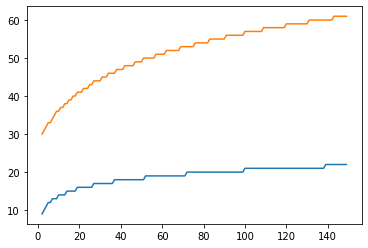

In [14]:
plt.plot(ds, k1_log_arr)
plt.plot(ds, k2_log_arr)

### Explain main idea of algorithms

In [11]:
from sklearn.linear_model import Ridge

In [12]:
df = []
name = 'Sphere'
N = 1000
ds = [6, 7, 8, 9]

for d in ds:
    data = DG.gen_data(name, N, d+1, d)
    res, id_data = geomle(data, k1=7, k2=40, nb_iter1=1, debug=True)
    df.append(id_data[0])

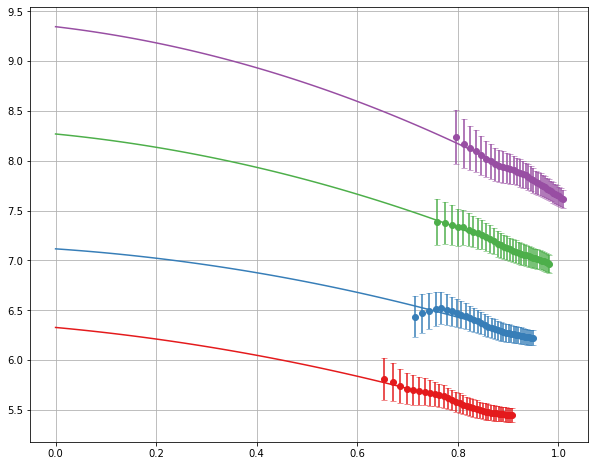

In [13]:
f, ax = plt.subplots(1, 1, figsize=(10, 8))


alpha_poly = (1, 2)
alpha_reg = 1e-2

cm = plt.cm.get_cmap('Set1', 10)
save_data = []


for i in range(len(df)):
    gr_df = df[i].groupby(['k', 'idx']).mean().reset_index().groupby('k')

    x = gr_df['R'].mean().values
    y = gr_df['dim'].mean().values
    w = gr_df['dim'].std().values
    save_data.append([x, y, w])
    X = np.array([x ** i for i in alpha_poly]).T

    xlin = np.linspace(0, x.max(), 100)
    Xlin = np.array([xlin ** i for i in alpha_poly]).T
    lm = Ridge(alpha=alpha_reg)
    lm.fit(X, y, w **-1)
    plt.errorbar(x, y, w * 0.1, fmt='o', color=cm(i), capsize=3, capthick=0.5)
    plt.plot(xlin, lm.predict(Xlin), color=cm(i))

# ax.legend()
ax.grid()
plt.show()


In [14]:
np.save('result/exp_new.npy', save_data)

## Density test

In [15]:
def gen_sphere_data_with_distribution(n, dim, d, distrib):
    if distrib == 'uniform':
        V = np.random.randn(n,d + 1)
    elif distrib == 'nonuniform':
        V = (np.random.rand(n,d + 1) - 0.5) * 3
    data = pd.DataFrame(np.hstack([V/np.sqrt(np.sum(V**2, axis=1))[:,None],
                                          np.zeros((n, dim - d - 1))]))
    assert data.shape == (n, dim)
    return data

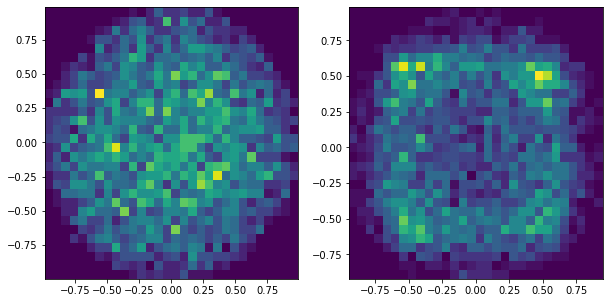

In [16]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
data = gen_sphere_data_with_distribution(5000, 5, 4, 'uniform')
plt.hist2d(data[0], data[1], bins=30)

plt.subplot(122)
data = gen_sphere_data_with_distribution(5000, 5, 4, 'nonuniform')
plt.hist2d(data[0], data[1], bins=30)

plt.show()

In [18]:
res = []
for i in tqdm(range(10)):
    data = gen_sphere_data_with_distribution(1000, 7, 5, 'uniform')
    res.append([mle(data)[0].mean(), geomle(data, nb_iter1=1, k1=10, k2=40).mean()])
                
mean = np.mean(res, axis=0)
std = np.std(res, axis=0)
print('Uniform')
print('MLE:    {:.4f}({:.4f})'.format(mean[0], std[0]))
print('GeoMLE: {:.4f}({:.4f})'.format(mean[1], std[1]))


res = []
for i in tqdm(range(10)):
    data = gen_sphere_data_with_distribution(1000, 7, 5, 'nonuniform')
    res.append([mle(data)[0].mean(), geomle(data, nb_iter1=1, k1=10, k2=40).mean()])
                
mean = np.mean(res, axis=0)
std = np.std(res, axis=0)
print('NonUniform')
print('MLE:    {:.4f}({:.4f})'.format(mean[0], std[0]))
print('GeoMLE: {:.4f}({:.4f})'.format(mean[1], std[1]))



  0%|          | 0/10 [00:00<?, ?it/s]

Uniform
MLE:    4.8659(0.0708)
GeoMLE: 5.1343(0.1778)


100%|██████████| 10/10 [00:20<00:00,  2.08s/it]

NonUniform
MLE:    4.5906(0.0485)
GeoMLE: 4.9855(0.1169)


## Funcs

In [126]:
def run_one_test(args):
    try:
        data = DG.gen_data(name = args['name'],
                           n = args['N'],
                           dim = args['D'],
                           d = args['d'],
                           type_sample = args['type_sample'],
                           noise = args['noise'])
        res, t = DE.estimateAllMethod(data)
        res['Dataset'] = args['name']
        res['Num'] = args['N']
        res['Dim'] = args['D']
        res['RealDim'] = args['d']
        t['Dataset'] = args['name']
        t['Num'] = args['N']
        t['Dim'] = args['D']
        t['RealDim'] = args['d']
        return list(res.values()), list(t.values())
    except:
        print('WRONG with {}'.format(args))


In [127]:
def run_test(func, steps, const_args, n_repetition, n_jobs=CPU_COUNT, return_time=False):
    with parallel_backend('multiprocessing'):
        result = Parallel(n_jobs=n_jobs)(delayed(func)(add_args(const_args, step))
                                 for step in tqdm(steps * n_repetition))
    result = [i for i in result if i is not None]
    times_res = np.array(list(map(ig1, result)))
    dims_res = np.array(list(map(ig0, result)))
    cols = DE.names + ['Dataset', 'Num', 'Dim', 'RealDim']
    df_res = df = pd.DataFrame(dims_res, columns=cols)
    df_time = pd.DataFrame(times_res, columns=cols)
    df_res = df_res.set_index('Dataset').astype('float').reset_index()
    df_time = df_time.set_index('Dataset').astype('float').reset_index()
    return df_res, df_time

## Dependacne of manifold dimension

In [21]:
DE = DimEst()
DG = DataGenerator()
DG.dict_gen.keys()

steps = np.arange(2, 100, 4).tolist()
args = {'name': 'Sphere',
        'D': 100,
        'N': 1000,
        'type_sample': 'uniform',
        'noise': 0}

In [22]:
def add_args(const_args, step):
    args = {**const_args}
    args['d'] = step
    assert len({'name', 'D', 'd', 'N', 'type_sample', 'noise'} & set(args.keys())) == 6
    return args

In [23]:
names = DE.names
n_repetition = 5

df, _ = run_test(run_one_test, steps, args, n_repetition)

100%|██████████| 125/125 [08:38<00:00,  4.34s/it]


In [24]:
df_mean = df.groupby(['Dataset', 'Num', 'Dim', 'RealDim']).mean().reset_index()

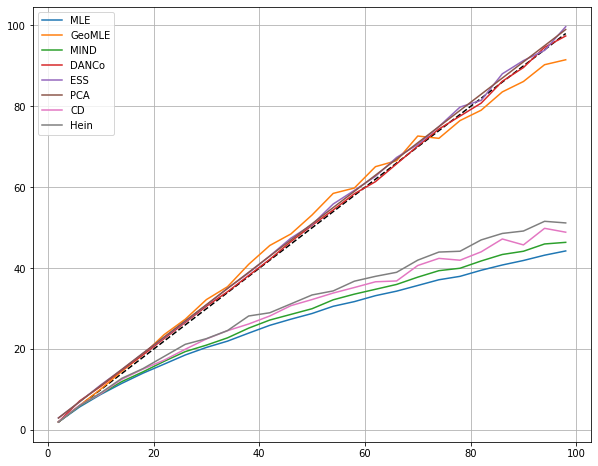

In [25]:
f, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.plot(df_mean['RealDim'], df_mean['RealDim'], '--', color='black')
for name in names:
    ax.plot(df_mean['RealDim'], df_mean[name], label=name)
    
ax.legend()
ax.grid()
plt.show()

In [26]:
df.to_csv('result/result_sphere.csv', index_label=False)

## Dolan More Curve

In [128]:
DE = DimEst()
DG = DataGenerator()

In [129]:
DG.dict_gen.keys()

dict_keys(['Helix1d', 'Helix2d', 'Helicoid', 'Spiral', 'Roll', 'Scurve', 'Star', 'Moebius', 'Sphere', 'Norm', 'Uniform', 'Cubic', 'Affine_3to5', 'Affine', 'Nonlinear_4to6', 'Nonlinear', 'Paraboloid'])

In [130]:
steps = [
    ('Sphere',  5,  3),
    ('Sphere',  10, 5),
    ('Sphere',  15, 10),
    ('Sphere',  35, 30),
    ('Sphere',  55, 50),
    ('Sphere',  75, 70),
    
    ('Affine_3to5',  5,  3),
    ('Affine',       5,  5),
    ('Affine',       10, 10),
    ('Affine',       20, 20),
    
    ('Nonlinear_4to6',  6,  4),
    ('Nonlinear',       8,  4),
    ('Nonlinear',       36, 6),
    ('Nonlinear',       64, 8),
    ('Nonlinear',       72, 12),
    
    ('Spiral',   3,  1),
    ('Spiral',   13, 1),
    ('Helix1d',  3,  1),
    ('Helix1d',  13, 1),
    ('Helix2d',  3,  2),
    ('Helix2d',  13, 2),
    ('Helicoid', 3,  2),
    ('Helicoid', 13, 2),
    ('Roll',     3,  2),
    ('Roll',     13, 2),
    ('Scurve',   3,  2),
    ('Scurve',   13, 2),
    ('Moebius',  3,  2),
    
    ('Uniform', 10, 5),
    ('Uniform', 15, 10),
    ('Uniform', 35, 30),
    ('Uniform', 55, 50),
    ('Uniform', 75, 70),
     
    ('Norm', 20, 20),
    ('Norm', 50, 20),
    ('Norm', 50, 50),
    ('Norm', 70, 50),
    
    ('Paraboloid', 12, 3),
    ('Paraboloid', 21, 6),
    ('Paraboloid', 30, 9),
    ('Paraboloid', 39, 12),
    ('Paraboloid', 48, 15),
    
    ('Cubic', 5,  3),
    ('Cubic', 35, 30),
    ('Cubic', 90, 70),
]

In [131]:
len(steps)

45

In [132]:
def add_args(const_args, step):
    args = {**const_args}
    args['name'] = step[0]
    args['D'] = step[1]
    args['d'] = step[2]
    assert len({'name', 'D', 'd', 'N', 'noise'} & set(args.keys())) == 5
    return args

In [133]:
n_repetition = 5
args = {'N': 1000, 'noise': 0, 'type_sample': 'uniform'}
df, df_time = run_test(run_one_test, steps, args, n_repetition)

 96%|█████████▋| 217/225 [19:31<00:37,  4.68s/it]

[1]
 1




 97%|█████████▋| 218/225 [19:36<00:32,  4.66s/it]

WRONG with {'N': 1000, 'noise': 0, 'type_sample': 'uniform', 'name': 'Roll', 'D': 13, 'd': 2}


100%|██████████| 225/225 [20:07<00:00,  6.55s/it]


In [134]:
df.groupby(['Dataset', 'Num', 'Dim', 'RealDim']).mean()

MLE     GeoMLE  MIND  DANCo  \
Dataset        Num    Dim  RealDim                                      
Affine         1000.0 5.0  5.0       4.305258   5.000000   4.0    5.0   
                      10.0 10.0      7.712303   9.912339   8.0    9.6   
                      20.0 20.0     13.310821  19.687696  14.0   19.0   
Affine_3to5    1000.0 5.0  3.0       2.738002   3.072325   3.0    3.0   
Cubic          1000.0 5.0  3.0       3.046447   3.117651   3.0    4.0   
                      35.0 30.0     18.235634  29.721372  19.2   29.8   
                      90.0 70.0     31.211757  74.293434  33.8   69.6   
Helicoid       1000.0 3.0  2.0       2.139040   2.314091   2.0    2.0   
                      13.0 2.0       2.118204   2.222067   2.0    2.0   
Helix1d        1000.0 3.0  1.0       1.088490   1.216671   1.0    1.0   
                      13.0 1.0       1.086904   1.278032   1.0    1.0   
Helix2d        1000.0 3.0  2.0       2.764936   2.677941   3.0    3.0   
                      13.0 2.0       2.767395   2.810647   3.0    3.0   
Moebius        1000.0 3.0  2.0       2.091290   1.278846   2.0    2.0   
Nonlinear      1000.0 8.0  4.0       4.340946   3.320108   4.0    5.0   
                      36.0 6.0       6.943705   6.708093   7.0    7.8   
                      64.0 8.0       9.252331  10.690596   9.0   11.2   
                      72.0 12.0     12.974117  17.306892  13.2   17.8   
Nonlinear_4to6 1000.0 6.0  4.0       3.700495   4.127521   4.0    4.0   
Norm           1000.0 20.0 20.0     13.873363  20.000000  15.0   20.0   
                      50.0 20.0     13.767693  21.519287  15.0   20.6   
                           50.0     24.476454  50.000000  27.0   47.8   
                      70.0 50.0     24.441226  52.875505  27.0   47.4   
Paraboloid     1000.0 12.0 3.0       2.734067   3.062384   3.0    3.2   
                      21.0 6.0       4.202450   5.961053   5.0    5.0   
                      30.0 9.0       4.801959   9.033189   5.0    6.0   
                      39.0 12.0      4.934400  12.250517   6.0    7.0   
                      48.0 15.0      4.721062  13.886602   6.0    6.8   
Roll           1000.0 3.0  2.0       1.956159   2.044432   2.0    2.0   
                      13.0 2.0       1.952086   2.207737   2.0    2.0   
Scurve         1000.0 3.0  2.0       1.912767   2.041083   2.0    2.0   
                      13.0 2.0       1.912798   2.011035   2.0    2.0   
Sphere         1000.0 5.0  3.0       2.972343   3.081803   3.0    4.0   
                      10.0 5.0       4.759788   5.092993   5.0    6.0   
                      15.0 10.0      8.533141  10.377820   9.0   11.0   
                      35.0 30.0     18.985804  32.463958  20.4   30.8   
                      55.0 50.0     26.528460  52.898723  28.4   51.2   
                      75.0 70.0     32.671610  70.743789  35.2   70.4   
Spiral         1000.0 3.0  1.0       1.740074   1.547418   2.0    2.0   
                      13.0 1.0       1.736327   1.559839   2.0    2.0   
Uniform        1000.0 10.0 5.0       4.310223   4.740012   4.4    5.0   
                      15.0 10.0      7.787836   9.176881   8.0    9.8   
                      35.0 30.0     17.839916  29.365858  19.0   28.8   
                      55.0 50.0     24.935675  51.173918  27.0   49.0   
                      75.0 70.0     31.016346  73.698438  33.8   69.2   

                                          ESS   PCA         CD  Hein  
Dataset        Num    Dim  RealDim                                    
Affine         1000.0 5.0  5.0       4.978156   5.0   4.574749   5.0  
                      10.0 10.0      9.967358  10.0   8.314556   8.0  
                      20.0 20.0     20.069427  20.0  14.577997  14.8  
Affine_3to5    1000.0 5.0  3.0       2.592155   3.0   2.888834   3.0  
Cubic          1000.0 5.0  3.0       3.990806   4.0   3.036158   3.0  
                      35.0 30.0     30.631984  31.0  20.529007  21.0  
                      90.0 70.0     71.025

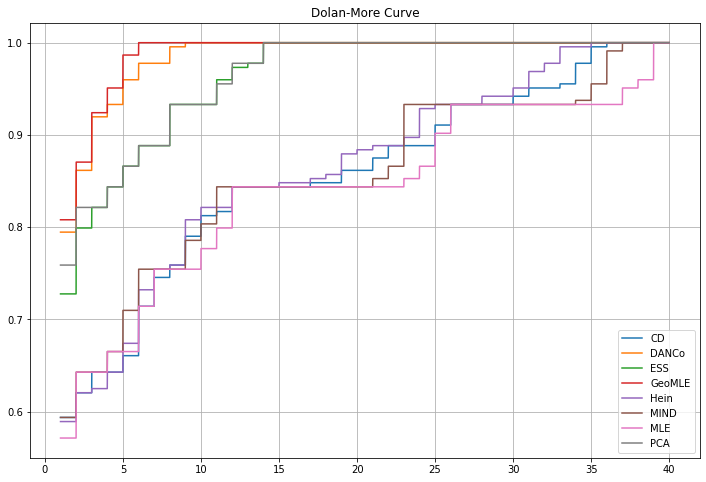

In [135]:
dfr = df.copy().round()
names = dfr.columns.difference(['Dataset', 'Num', 'Dim', 'RealDim'])

f, ax = plt.subplots(1, 1, figsize=(12, 8))
nsteps = 5001
max_tau = 40
errors_total = abs(dfr[names].sub(dfr['RealDim'], axis=0).values)
errors_total = np.max([errors_total, np.ones_like(errors_total)], axis=0)


taus = np.linspace(1, max_tau, nsteps)        
rhos = np.zeros((nsteps, len(names)))
for cnt, tau in enumerate(taus):
    rhos[cnt] = np.sum(errors_total <= tau, axis=0)

for i in range(len(names)):
    ax.plot(taus, rhos[:,i]/errors_total.shape[0], label=names[i])

ax.set_title('Dolan-More Curve')
ax.legend()
ax.grid()




In [137]:
abs(dfr[names].sub(dfr['RealDim'], axis=0)).mul(dfr['RealDim']**-1, axis=0).mean(axis=0)

CD        0.193988
DANCo     0.164122
ESS       0.384890
GeoMLE    0.108177
Hein      0.188248
MIND      0.248055
MLE       0.269471
PCA       0.421967
dtype: float64

In [143]:
df.to_csv('result/result_dm_new.csv', index_label=False)


In [33]:
df.groupby(['Dataset', 'Num', 'Dim', 'RealDim']).mean()

MLE     GeoMLE  MIND  DANCo  \
Dataset        Num    Dim  RealDim                                      
Affine         1000.0 5.0  5.0       4.436176   5.000000   4.7    5.0   
                      10.0 10.0      8.092389  10.000000   8.1    9.5   
                      20.0 20.0     14.110037  19.837311  14.5   19.3   
Affine_3to5    1000.0 5.0  3.0       2.819162   3.125630   3.0    3.0   
Cubic          1000.0 5.0  3.0       3.069715   3.120422   3.0    3.0   
                      35.0 30.0     19.548624  30.146128  20.5   30.8   
                      90.0 70.0     34.217167  73.697099  35.9   73.4   
Helicoid       1000.0 3.0  2.0       2.086243   2.263129   2.0    2.0   
                      13.0 2.0       2.079526   2.286545   2.0    2.0   
Helix1d        1000.0 3.0  1.0       1.002463   1.399572   1.0    1.0   
                      13.0 1.0       1.002080   1.403783   1.0    1.0   
Helix2d        1000.0 3.0  2.0       2.741861   2.772936   2.9    3.0   
                      13.0 2.0       2.743644   2.833216   2.9    3.0   
Moebius        1000.0 3.0  2.0       1.985567   1.271459   2.0    2.0   
Nonlinear      1000.0 8.0  4.0       4.076561   3.409430   4.0    5.7   
                      36.0 6.0       6.683937   6.807444   6.0    8.1   
                      64.0 8.0       9.210539  10.525456   9.0   10.5   
                      72.0 12.0     13.437732  17.379927  13.6   17.5   
Nonlinear_4to6 1000.0 6.0  4.0       3.825456   4.138118   4.0    5.0   
Norm           1000.0 20.0 20.0     14.988604  20.000000  15.6   20.0   
                      50.0 20.0     14.989692  22.124816  15.8   21.4   
                           50.0     27.026298  50.000000  28.6   47.5   
                      70.0 50.0     27.168977  53.282319  28.7   52.9   
Paraboloid     1000.0 12.0 3.0       2.830874   2.999793   3.0    3.0   
                      21.0 6.0       4.707588   6.011846   5.0    6.4   
                      30.0 9.0       5.882575   9.163055   6.0    8.0   
                      39.0 12.0      6.611216  12.152166   7.0    8.3   
                      48.0 15.0      6.974033  13.636721   7.4    8.7   
Roll           1000.0 3.0  2.0       1.954331   2.275757   2.0    2.0   
                      13.0 2.0       1.947018   2.317430   2.0    2.0   
Scurve         1000.0 3.0  2.0       1.946351   2.037241   2.0    2.0   
                      13.0 2.0       1.948070   2.048969   2.0    2.0   
Sphere         1000.0 5.0  3.0       2.980354   3.082889   3.0    3.0   
                      10.0 5.0       4.814091   5.070053   5.0    6.0   
                      15.0 10.0      8.834389   9.977898   9.0   11.2   
                      35.0 30.0     20.290503  32.557897  20.9   30.4   
                      55.0 50.0     28.893689  52.645787  30.2   50.6   
                      75.0 70.0     35.904561  71.800092  37.7   69.9   
Spiral         1000.0 3.0  1.0       1.761830   1.522823   1.0    1.0   
                      13.0 1.0       1.766377   1.526826   1.0    1.0   
Uniform        1000.0 10.0 5.0       4.453239   4.721269   4.8    5.0   
                      15.0 10.0      8.081392   9.156182   8.1    9.8   
                      35.0 30.0     19.048783  29.433654  19.9   30.1   
                      55.0 50.0     27.195976  51.231300  28.7   50.9   
                      75.0 70.0     33.930374  72.475144  35.9   70.9   

                                          ESS   PCA         CD  Hein  
Dataset        Num    Dim  RealDim                                    
Affine         1000.0 5.0  5.0       4.961017   5.0   4.737116   4.8  
                      10.0 10.0     10.020648  10.0   8.609721   8.5  
                      20.0 20.0     20.012921  20.0  14.791872  15.2  
Affine_3to5    1000.0 5.0  3.0       2.581466   3.0   2.917733   3.0  
Cubic          1000.0 5.0  3.0       3.953560   4.0   3.058121   3.0  
                      35.0 30.0     30.946966  31.0  20.579042  21.3  
                      90.0 70.0     71.543

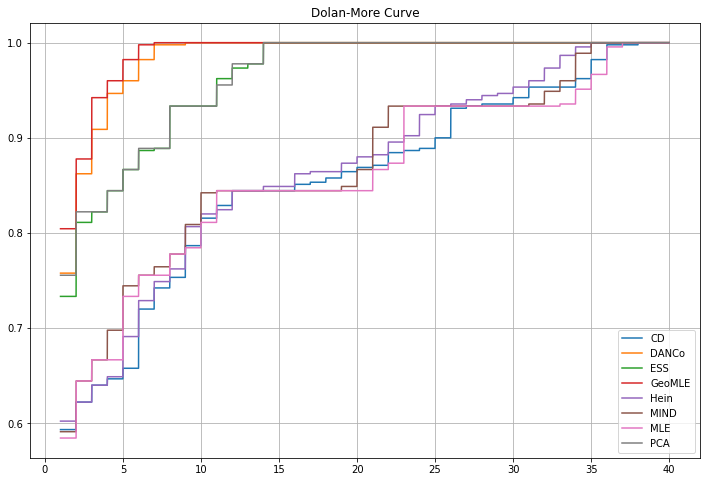

In [34]:
dfr = df.copy().round()
names = dfr.columns.difference(['Dataset', 'Num', 'Dim', 'RealDim'])

f, ax = plt.subplots(1, 1, figsize=(12, 8))
nsteps = 5001
max_tau = 40
errors_total = abs(dfr[names].sub(dfr['RealDim'], axis=0).values)
errors_total = np.max([errors_total, np.ones_like(errors_total)], axis=0)


taus = np.linspace(1, max_tau, nsteps)        
rhos = np.zeros((nsteps, len(names)))
for cnt, tau in enumerate(taus):
    rhos[cnt] = np.sum(errors_total <= tau, axis=0)

for i in range(len(names)):
    ax.plot(taus, rhos[:,i]/errors_total.shape[0], label=names[i])

ax.set_title('Dolan-More Curve')
ax.legend()
ax.grid()



In [35]:
df.to_csv('result/result_dm.csv', index_label=False)

### Nonunform samplings

In [32]:
DE = DimEst()
DG = DataGenerator()

In [33]:
DG.dict_gen.keys()

dict_keys(['Helix1d', 'Helix2d', 'Helicoid', 'Spiral', 'Roll', 'Scurve', 'Star', 'Moebius', 'Sphere', 'Norm', 'Uniform', 'Cubic', 'Affine_3to5', 'Affine', 'Nonlinear_4to6', 'Nonlinear', 'Paraboloid'])

In [34]:
steps = [
    ('Sphere',  5,  3),
    ('Sphere',  10, 5),
    ('Sphere',  15, 10),
    ('Sphere',  35, 30),
    ('Sphere',  55, 50),
    ('Sphere',  75, 70),
    
    ('Affine_3to5',  5,  3),
    ('Affine',       5,  5),
    ('Affine',       10, 10),
    ('Affine',       20, 20),
    
    ('Nonlinear_4to6',  6,  4),
    ('Nonlinear',       8,  4),
    ('Nonlinear',       36, 6),
    ('Nonlinear',       64, 8),
    ('Nonlinear',       72, 12),
    
    ('Spiral',   3,  1),
    ('Spiral',   13, 1),
    ('Helix1d',  3,  1),
    ('Helix1d',  13, 1),
    ('Helix2d',  3,  2),
    ('Helix2d',  13, 2),
    ('Helicoid', 3,  2),
    ('Helicoid', 13, 2),
    ('Roll',     3,  2),
    ('Roll',     13, 2),
    ('Scurve',   3,  2),
    ('Scurve',   13, 2),
    ('Moebius',  3,  2),
    
    ('Norm', 10, 5),
    ('Norm', 15, 10),
    ('Norm', 35, 30),
    ('Norm', 55, 50),
    ('Norm', 75, 70),
     
#     ('Norm', 20, 20),
#     ('Norm', 50, 20),
#     ('Norm', 50, 50),
#     ('Norm', 70, 50),
    
    ('Paraboloid', 12, 3),
    ('Paraboloid', 21, 6),
    ('Paraboloid', 30, 9),
    ('Paraboloid', 39, 12),
    ('Paraboloid', 48, 15),
    
#     ('Cubic', 5,  3),
#     ('Cubic', 35, 30),
#     ('Cubic', 90, 70),
]

In [35]:
def add_args(const_args, step):
    args = {**const_args}
    args['name'] = step[0]
    args['D'] = step[1]
    args['d'] = step[2]
    assert len({'name', 'D', 'd', 'N', 'noise'} & set(args.keys())) == 5
    return args

In [37]:
n_repetition = 10
args = {'N': 1000, 'noise': 0, 'type_sample': 'nonuniform'}
df, df_time = run_test(run_one_test, steps, args, n_repetition)

100%|██████████| 380/380 [06:53<00:00,  1.26it/s]


In [38]:
df.groupby(['Dataset', 'Num', 'Dim', 'RealDim']).mean()

MLE     GeoMLE  MIND  DANCo  \
Dataset        Num    Dim  RealDim                                      
Affine         1000.0 5.0  5.0       5.020814   4.998816   5.0    5.0   
                      10.0 10.0      8.990513  10.000000   9.0   10.0   
                      20.0 20.0     15.107916  20.000000  15.9   19.9   
Affine_3to5    1000.0 5.0  3.0       3.063209   3.037318   3.0    3.1   
Helicoid       1000.0 3.0  2.0       2.099377   2.022600   2.0    2.0   
                      13.0 2.0       2.096877   2.018808   2.0    2.0   
Helix1d        1000.0 3.0  1.0       1.069185   0.936972   1.0    1.0   
                      13.0 1.0       1.045382   0.584697   1.0    1.0   
Helix2d        1000.0 3.0  2.0       2.471712   1.549056   2.0    2.1   
                      13.0 2.0       2.472843   1.806733   2.0    2.0   
Moebius        1000.0 3.0  2.0       2.062018   2.022438   2.0    2.0   
Nonlinear      1000.0 8.0  4.0       4.081218   3.993467   4.0    5.0   
                      36.0 6.0       5.998835   6.423197   6.0    7.1   
                      64.0 8.0       7.792259   8.730836   8.0    9.0   
                      72.0 12.0     10.855378  13.433242  11.0   13.2   
Nonlinear_4to6 1000.0 6.0  4.0       3.926262   4.070970   4.0    5.0   
Norm           1000.0 10.0 5.0       4.990759   5.396950   5.0    6.0   
                      15.0 10.0      9.023456  10.704392   9.1   10.3   
                      35.0 30.0     19.672006  32.112742  20.6   31.4   
                      55.0 50.0     27.073239  51.709286  28.4   50.7   
                      75.0 70.0     33.057989  72.317066  35.1   68.2   
Paraboloid     1000.0 12.0 3.0       2.832962   2.941758   3.0    3.0   
                      21.0 6.0       4.729833   5.812629   5.0    6.6   
                      30.0 9.0       5.931393   8.692435   6.0    8.0   
                      39.0 12.0      6.644121  11.836172   7.0    8.2   
                      48.0 15.0      6.962873  14.016743   7.4    8.8   
Roll           1000.0 3.0  2.0       2.033722   2.035524   2.0    2.0   
                      13.0 2.0       2.048561   2.105231   2.0    2.0   
Scurve         1000.0 3.0  2.0       2.033442   2.006502   2.0    2.0   
                      13.0 2.0       2.040631   2.032976   2.0    2.0   
Sphere         1000.0 5.0  3.0       2.961716   3.019967   3.0    3.0   
                      10.0 5.0       4.631092   4.740091   5.0    6.1   
                      15.0 10.0      8.189919   8.526787   8.1   10.4   
                      35.0 30.0     19.792762  29.582027  20.5   29.6   
                      55.0 50.0     28.389587  50.090070  29.7   49.5   
                      75.0 70.0     35.100652  67.677164  36.7   69.3   
Spiral         1000.0 3.0  1.0       1.547495   1.974704   1.0    1.0   
                      13.0 1.0       1.528277   1.952715   1.0    1.0   

                                          ESS   PCA         CD  Hein  
Dataset        Num    Dim  RealDim                                    
Affine         1000.0 5.0  5.0       4.968821   5.0   4.813513   5.0  
                      10.0 10.0     10.046645  10.0   8.437193   8.8  
                      20.0 20.0     19.893082  20.0  13.587803  14.4  
Affine_3to5    1000.0 5.0  3.0       2.622393   3.0   2.985264   3.0  
Helicoid       1000.0 3.0  2.0       2.595938   3.0   2.028393   2.0  
                      13.0 2.0       2.591167   3.0   2.015797   2.0  
Helix1d        1000.0 3.0  1.0       2.878401   3.0   0.959202   1.0  
                      13.0 1.0       2.857758   3.0   0.975039   1.0  
Helix2d        1000.0 3.0  2.0       2.093870   2.0   2.015928   2.0  
                      13.0 2.0       2.112224   2.0   1.964734   2.0  
Moebius        1000.0 3.0  2.0       1.805454   2.0   1.988716   2.0  
Nonlinear      1000.0 8.0  4.0       5.195866   8.0   3.870462   4.0  
                      36.0 6.0       7.779084  12.0   5.654124   5.9  
                      64.0 8.0      10.451486  16.0   7.

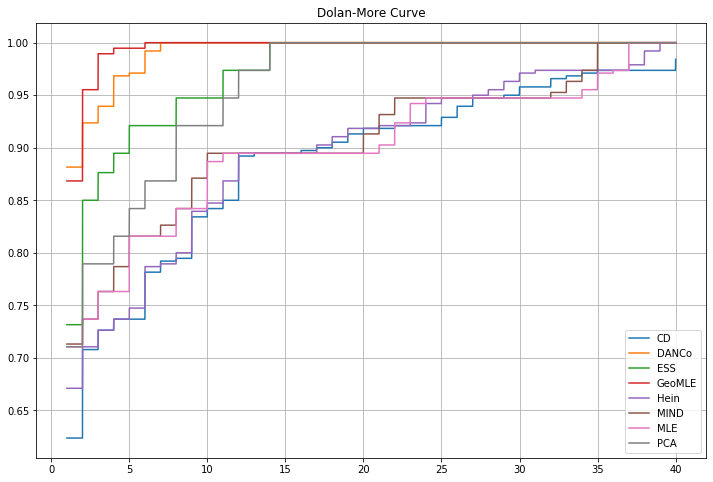

In [39]:
dfr = df.copy().round()
names = dfr.columns.difference(['Dataset', 'Num', 'Dim', 'RealDim'])

f, ax = plt.subplots(1, 1, figsize=(12, 8))
nsteps = 5001
max_tau = 40
errors_total = abs(dfr[names].sub(dfr['RealDim'], axis=0).values)
errors_total = np.max([errors_total, np.ones_like(errors_total)], axis=0)


taus = np.linspace(1, max_tau, nsteps)        
rhos = np.zeros((nsteps, len(names)))
for cnt, tau in enumerate(taus):
    rhos[cnt] = np.sum(errors_total <= tau, axis=0)

for i in range(len(names)):
    ax.plot(taus, rhos[:,i]/errors_total.shape[0], label=names[i])

ax.set_title('Dolan-More Curve')
ax.legend()
ax.grid()



In [40]:
df.to_csv('result/result_nonuniform_dm.csv', index_label=False)

## Dependece on noise

In [36]:
DE = DimEst()
DG = DataGenerator()

In [37]:
DG.dict_gen.keys()

dict_keys(['Helix1d', 'Helix2d', 'Helicoid', 'Spiral', 'Roll', 'Scurve', 'Star', 'Moebius', 'Sphere', 'Norm', 'Uniform', 'Cubic', 'Affine_3to5', 'Affine', 'Nonlinear_4to6', 'Nonlinear', 'Paraboloid'])

In [38]:
steps = [
    ('Sphere',  5,  3),
    ('Sphere',  10, 5),
    ('Sphere',  15, 10),
    ('Sphere',  35, 30),
    ('Sphere',  55, 50),
    ('Sphere',  75, 70),
    
    ('Affine_3to5',  5,  3),
    ('Affine',       5,  5),
    ('Affine',       10, 10),
    ('Affine',       20, 20),
    
    ('Nonlinear_4to6',  6,  4),
    ('Nonlinear',       8,  4),
    ('Nonlinear',       36, 6),
    ('Nonlinear',       64, 8),
    ('Nonlinear',       72, 12),
    
    ('Spiral',   3,  1),
    ('Spiral',   13, 1),
    ('Helix1d',  3,  1),
    ('Helix1d',  13, 1),
    ('Helix2d',  3,  2),
    ('Helix2d',  13, 2),
    ('Helicoid', 3,  2),
    ('Helicoid', 13, 2),
    ('Roll',     3,  2),
    ('Roll',     13, 2),
    ('Scurve',   3,  2),
    ('Scurve',   13, 2),
    ('Moebius',  3,  2),
    
    ('Uniform', 10, 5),
    ('Uniform', 15, 10),
    ('Uniform', 35, 30),
    ('Uniform', 55, 50),
    ('Uniform', 75, 70),
     
    ('Norm', 20, 20),
    ('Norm', 50, 20),
    ('Norm', 50, 50),
    ('Norm', 70, 50),
    
    ('Paraboloid', 12, 3),
    ('Paraboloid', 21, 6),
    ('Paraboloid', 30, 9),
    ('Paraboloid', 39, 12),
    ('Paraboloid', 48, 15),
    
    ('Cubic', 5,  3),
    ('Cubic', 35, 30),
    ('Cubic', 90, 70),
]

In [39]:
len(steps)

45

In [45]:
def add_args(const_args, step):
    args = {}
    args['N'] = const_args['N']
    args['noise'] = const_args['noise']
    args['type_sample'] = const_args['type_sample']
    args['name'] = step[0]
    args['D'] = step[1]
    args['d'] = step[2]
    return args

In [46]:
noise_steps = [0, 0.01, 0.02, 0.03, 0.04, 0.05]                     

In [48]:
names = DE.names
n_repetition = 5

mpe = []
std = []
for noise in noise_steps:
    args = {'N': 1000, 'noise': noise, 'type_sample': 'uniform'}
    df, _ = run_test(run_one_test, steps, args, n_repetition, 12)
    dfr = df.round()
    mpe_i = abs(dfr[names].sub(dfr['RealDim'], axis=0)).mul(dfr['RealDim']**-1, axis=0).values
    mpe.append(mpe_i.mean(axis=0))
    std.append(mpe_i.std(axis=0)/np.sqrt(mpe_i.shape[0]))

mpe = np.array(mpe)
std = np.array(std)

100%|██████████| 225/225 [04:27<00:00,  1.03s/it]


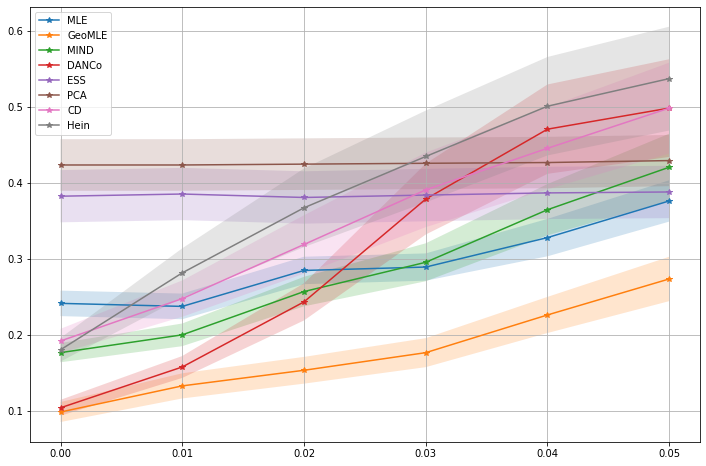

In [49]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))

for mpe_i, std_i, name in zip(mpe.T, std.T, names):
    ax.plot(noise_steps, mpe_i, '-*', label=name)
    ax.fill_between(noise_steps, mpe_i - std_i, mpe_i + std_i, alpha=0.2)
    
ax.legend()
ax.grid()
plt.show()

In [50]:
result = pd.DataFrame(mpe, columns=names)
result['noise'] = noise_steps
result.to_csv('result/result_noise_mpe.csv', index_label=False)

In [51]:
result = pd.DataFrame(std, columns=names)
result['noise'] = noise_steps
result.to_csv('result/result_noise_std.csv', index_label=False)

## Time dependance

### Dim

In [109]:
DE = DimEst()
DG = DataGenerator()
DG.dict_gen.keys()

steps = np.arange(5, 101, 5).tolist()
args = {'name': 'Sphere',
        'N': 1000,
        'noise': 0}

In [110]:
def add_args(const_args, step):
    args = {**const_args}
    args['d'] = step
    args['D'] = step + 1
    assert len({'name', 'D', 'd', 'N', 'noise'} & set(args.keys())) == 5
    return args

In [111]:
names = DE.names
n_repetition = 5

df = run_test(run_one_test, steps, args, n_repetition, return_time=True)

100%|██████████| 100/100 [03:14<00:00,  2.68s/it]


In [114]:
df_mean = df.groupby(['Dataset', 'Num', 'Dim', 'RealDim']).mean().reset_index()

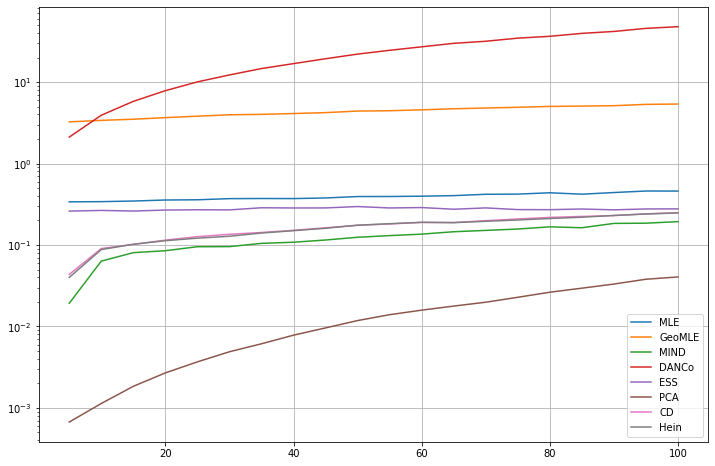

In [117]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))

for name in names:
    ax.plot(df_mean['RealDim'], df_mean[name], label=name)
    
plt.yscale('log')
ax.legend()
ax.grid()
plt.show()

In [118]:
df.to_csv('result/result_time_dim.csv', index_label=False)

### Num

In [29]:
DE = DimEst()
DG = DataGenerator()
DG.dict_gen.keys()

steps = np.concatenate((np.arange(100, 1000, 200), 
                          np.arange(1000, 2000, 250), 
                          np.arange(2000, 10001, 500))).tolist()  
args = {'name': 'Sphere',
        'D': 11,
        'd': 10,
        'noise': 0}

In [30]:
def add_args(const_args, step):
    args = {**const_args}
    args['N'] = step
    assert len({'name', 'D', 'd', 'N', 'noise'} & set(args.keys())) == 5
    return args

In [31]:
names = DE.names
n_repetition = 5

df = run_test(run_one_test, steps, args, n_repetition, return_time=True)

 95%|█████████▌| 124/130 [06:18<00:14,  2.48s/it]

WRONG with {'name': 'Sphere', 'D': 11, 'd': 10, 'noise': 0, 'N': 8000}


100%|██████████| 130/130 [06:33<00:00,  2.89s/it]


In [32]:
df_mean = df.groupby(['Dataset', 'Num', 'Dim', 'RealDim']).mean().reset_index()

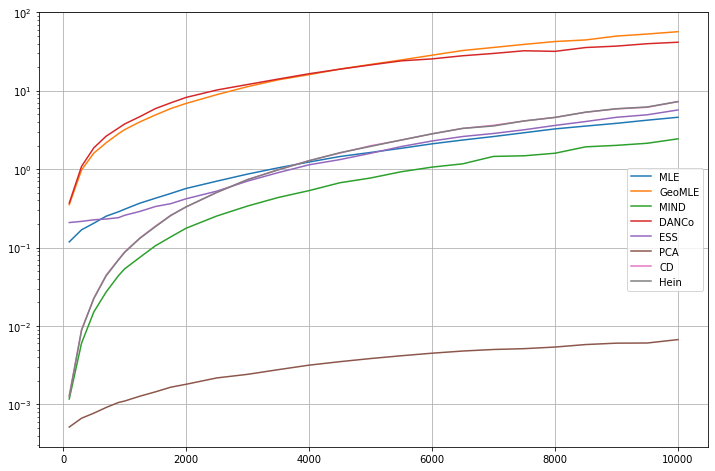

In [33]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))

for name in names:
    ax.plot(df_mean['Num'], df_mean[name], label=name)
    
plt.yscale('log')
ax.legend()
ax.grid()
plt.show()

In [34]:
df.to_csv('result/result_time_num.csv', index_label=False)

## EXTRA EXPERIMENTS

## Dependacne of Num points

In [52]:
DE = DimEst()
DG = DataGenerator()

In [53]:
DG.dict_gen.keys()

dict_keys(['Helix1d', 'Helix2d', 'Helicoid', 'Spiral', 'Roll', 'Scurve', 'Star', 'Moebius', 'Sphere', 'Norm', 'Uniform', 'Cubic', 'Affine_3to5', 'Affine', 'Nonlinear_4to6', 'Nonlinear', 'Paraboloid'])

In [54]:
steps = [
    ('Sphere',  5,  3),
    ('Sphere',  10, 5),
    ('Sphere',  15, 10),
    ('Sphere',  35, 30),
    ('Sphere',  55, 50),
    ('Sphere',  75, 70),
    ('Sphere',  100, 75),
    ('Sphere',  125, 100),
    
    ('Affine_3to5',  5,  3),
    ('Affine',       5,  5),
    ('Affine',       10, 10),
    ('Affine',       20, 20),
    
    ('Nonlinear_4to6',  6,  4),
    ('Nonlinear',       8,  4),
    ('Nonlinear',       36, 6),
    ('Nonlinear',       64, 8),
    ('Nonlinear',       72, 12),
    
    ('Spiral',   3,  1),
    ('Spiral',   13, 1),
    ('Helix1d',  3,  1),
    ('Helix1d',  13, 1),
    ('Helix2d',  3,  2),
    ('Helix2d',  13, 2),
    ('Helicoid', 3,  2),
    ('Helicoid', 13, 2),
    ('Roll',     3,  2),
    ('Roll',     13, 2),
    ('Scurve',   3,  2),
    ('Scurve',   13, 2),
    ('Moebius',  3,  2),
    
    ('Uniform', 10, 5),
    ('Uniform', 15, 10),
    ('Uniform', 35, 30),
    ('Uniform', 55, 50),
    ('Uniform', 75, 70),
     
    ('Norm', 20, 20),
    ('Norm', 50, 20),
    ('Norm', 50, 50),
    ('Norm', 70, 50),
    
    ('Paraboloid', 12, 3),
    ('Paraboloid', 21, 6),
    ('Paraboloid', 30, 9),
    ('Paraboloid', 39, 12),
    ('Paraboloid', 48, 15),
    
    ('Cubic', 5,  3),
    ('Cubic', 35, 30),
    ('Cubic', 90, 70),
]

In [55]:
len(steps)

47

In [60]:
N_steps = np.concatenate((np.arange(100, 1000, 200), 
                          np.arange(1000, 2000, 250),
                          np.arange(2000, 2501, 500)))                      

In [61]:
N_steps

array([ 100,  300,  500,  700,  900, 1000, 1250, 1500, 1750, 2000, 2500])

In [62]:
all_steps = [(N, name, D, d) for name, D, d in steps for N in N_steps]

In [63]:
len(all_steps)

517

In [67]:
def add_args(const_args, step):
    args = {}
    args['noise'] = const_args['noise']
    args['type_sample'] = const_args['type_sample']
    args['N'] = step[0]
    args['name'] = step[1]
    args['D'] = step[2]
    args['d'] = step[3]
    return args

In [68]:
names = DE.names
n_repetition = 5

mpe = []
args = {'noise': 0, 'type_sample': 'uniform'}
df = run_test(run_one_test, all_steps, args, n_repetition)

  5%|▌         | 133/2585 [04:50<54:49,  1.34s/it]  

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Affine', 'D': 20, 'd': 20}


  6%|▌         | 155/2585 [05:31<1:26:18,  2.13s/it]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Nonlinear', 'D': 8, 'd': 4}


 12%|█▏        | 298/2585 [09:25<39:56,  1.05s/it]  

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Roll', 'D': 13, 'd': 2}


 14%|█▍        | 364/2585 [10:14<35:10,  1.05it/s]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Uniform', 'D': 35, 'd': 30}


 17%|█▋        | 430/2585 [12:59<1:56:00,  3.23s/it]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Norm', 'D': 70, 'd': 50}


 18%|█▊        | 463/2585 [14:30<1:31:24,  2.58s/it]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Paraboloid', 'D': 30, 'd': 9}


 18%|█▊        | 474/2585 [14:49<1:27:14,  2.48s/it]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Paraboloid', 'D': 39, 'd': 12}


 19%|█▉        | 496/2585 [15:37<1:07:26,  1.94s/it]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Cubic', 'D': 5, 'd': 3}


 20%|█▉        | 507/2585 [15:57<1:19:22,  2.29s/it]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Cubic', 'D': 35, 'd': 30}


 21%|██        | 530/2585 [16:51<1:41:33,  2.97s/it]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Sphere', 'D': 5, 'd': 3}


 23%|██▎       | 595/2585 [19:10<1:26:23,  2.60s/it]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Sphere', 'D': 100, 'd': 75}


 25%|██▌       | 650/2585 [22:52<51:24,  1.59s/it]  

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Affine', 'D': 20, 'd': 20}


 28%|██▊       | 716/2585 [25:40<2:30:51,  4.84s/it]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Spiral', 'D': 3, 'd': 1}


 29%|██▉       | 749/2585 [26:32<39:37,  1.29s/it]  

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Helix1d', 'D': 13, 'd': 1}


 36%|███▌      | 925/2585 [30:15<1:37:50,  3.54s/it]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Norm', 'D': 50, 'd': 20}


 39%|███▉      | 1013/2585 [33:59<56:06,  2.14s/it]  

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Cubic', 'D': 5, 'd': 3}


 49%|████▉     | 1277/2585 [45:17<26:39,  1.22s/it]  

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Helix2d', 'D': 3, 'd': 2}


 55%|█████▌    | 1430/2585 [48:13<1:45:58,  5.51s/it]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Norm', 'D': 20, 'd': 20}


 59%|█████▉    | 1519/2585 [52:06<1:04:08,  3.61s/it]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Paraboloid', 'D': 48, 'd': 15}


 62%|██████▏   | 1596/2585 [54:34<28:35,  1.73s/it]  

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Sphere', 'D': 35, 'd': 30}


 66%|██████▌   | 1706/2585 [1:00:37<32:42,  2.23s/it]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Nonlinear', 'D': 8, 'd': 4}


 69%|██████▉   | 1783/2585 [1:03:35<22:17,  1.67s/it]  

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Helix1d', 'D': 13, 'd': 1}


 70%|███████   | 1816/2585 [1:04:10<09:18,  1.38it/s]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Helicoid', 'D': 3, 'd': 2}


 72%|███████▏  | 1871/2585 [1:05:00<11:00,  1.08it/s]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Scurve', 'D': 13, 'd': 2}


 77%|███████▋  | 1992/2585 [1:09:08<42:39,  4.32s/it]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Paraboloid', 'D': 12, 'd': 3}


 78%|███████▊  | 2025/2585 [1:10:15<23:05,  2.47s/it]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Paraboloid', 'D': 39, 'd': 12}


 83%|████████▎ | 2157/2585 [1:15:56<55:59,  7.85s/it]  

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Sphere', 'D': 125, 'd': 100}


 86%|████████▌ | 2212/2585 [1:18:46<12:09,  1.96s/it]  

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Nonlinear_4to6', 'D': 6, 'd': 4}


 87%|████████▋ | 2245/2585 [1:19:40<10:57,  1.93s/it]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Nonlinear', 'D': 64, 'd': 8}


 89%|████████▉ | 2311/2585 [1:22:26<05:48,  1.27s/it]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Helix2d', 'D': 3, 'd': 2}


 92%|█████████▏| 2366/2585 [1:23:17<03:04,  1.18it/s]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Roll', 'D': 13, 'd': 2}


 92%|█████████▏| 2376/2585 [1:23:26<03:01,  1.15it/s]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Scurve', 'D': 3, 'd': 2}


 97%|█████████▋| 2520/2585 [1:28:18<03:41,  3.40s/it]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Paraboloid', 'D': 21, 'd': 6}


 99%|█████████▉| 2553/2585 [1:29:20<01:38,  3.08s/it]

WRONG with {'noise': 0, 'type_sample': 'uniform', 'N': 100, 'name': 'Paraboloid', 'D': 48, 'd': 15}


100%|██████████| 2585/2585 [1:30:17<00:00,  1.60s/it]


In [71]:
df, _ = df

In [72]:
dfr = df.round()

In [73]:
names

['MLE', 'GeoMLE', 'MIND', 'DANCo', 'ESS', 'PCA', 'CD', 'Hein']

In [74]:
dfr[names] = abs(dfr[names].sub(dfr['RealDim'], axis=0)).mul(dfr['RealDim']**-1, axis=0)

mpe = dfr.groupby('Num')[names].mean().values
std = dfr.groupby('Num')[names].std().values / dfr.groupby('Num')[names].count().values

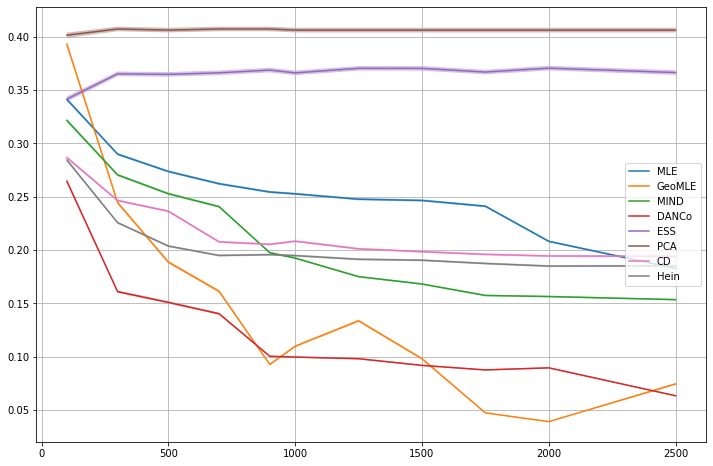

In [75]:
f, ax = plt.subplots(1, 1, figsize=(12, 8))

for mpe_i, std_i, name in zip(mpe.T, std.T, names):
    ax.plot(N_steps, mpe_i, label=name)
    ax.fill_between(N_steps, mpe_i-std_i, mpe_i+std_i, alpha=0.4)
    
ax.legend(loc=5)
ax.grid()
plt.show()

In [63]:
df.to_csv('result/result_num.csv', index_label=False)